In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten,AveragePooling2D
from tensorflow.keras.applications import EfficientNetB0 as EfficientNet
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image


In [2]:
dataset_dir = "assets/datasetv2"
train_dir = f"{dataset_dir}/train"
validation_dir = f"{dataset_dir}/valid"
test_dir = f"{dataset_dir}/test"

print(train_dir)

assets/datasetv2/train


In [3]:
def count_images_in_folder(folder_path):
    class_counts = {}
    for label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, label)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[label] = num_images
    return class_counts

In [4]:
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

def count_images_in_folder(folder_path):
    class_counts = {}
    for label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, label)
        if os.path.isdir(class_folder):
            num_images = len([
                f for f in os.listdir(class_folder) 
                if os.path.isfile(os.path.join(class_folder, f))
            ])
            class_counts[label] = num_images
    return class_counts

train_class_counts = count_images_in_folder(train_dir)
validation_class_counts = count_images_in_folder(validation_dir)
test_class_counts = count_images_in_folder(test_dir)

print("\nTraining data:", train_class_counts)
print("Validation data:", validation_class_counts)
print("Test data:", test_class_counts)


Found 341 images belonging to 3 classes.
Found 136 images belonging to 3 classes.
Found 105 images belonging to 3 classes.

Training data: {'moderate': 114, 'nomal': 114, 'severe': 113}
Validation data: {'moderate': 43, 'nomal': 49, 'severe': 44}
Test data: {'moderate': 36, 'nomal': 35, 'severe': 34}


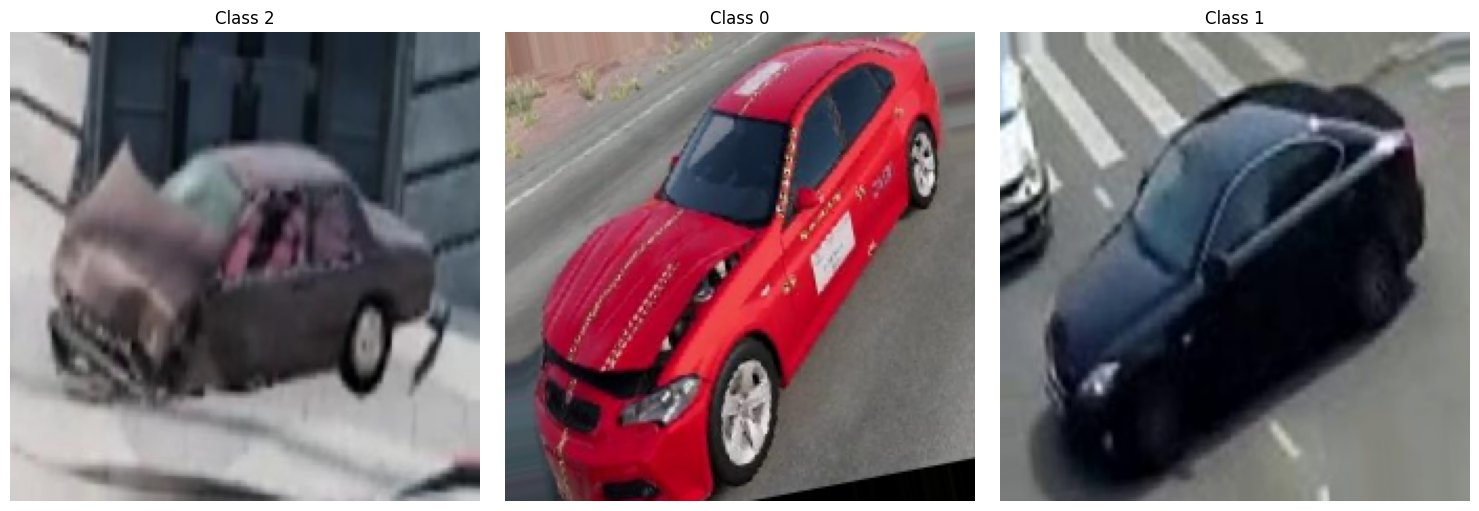

In [ ]:
images, labels = next(train_generator)
plt.figure(figsize=(15, 5))

for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i] / 255)
        plt.axis("off")
        class_label = np.argmax(labels[i] )
        plt.title(f"Class {class_label}")

plt.tight_layout()
plt.show()

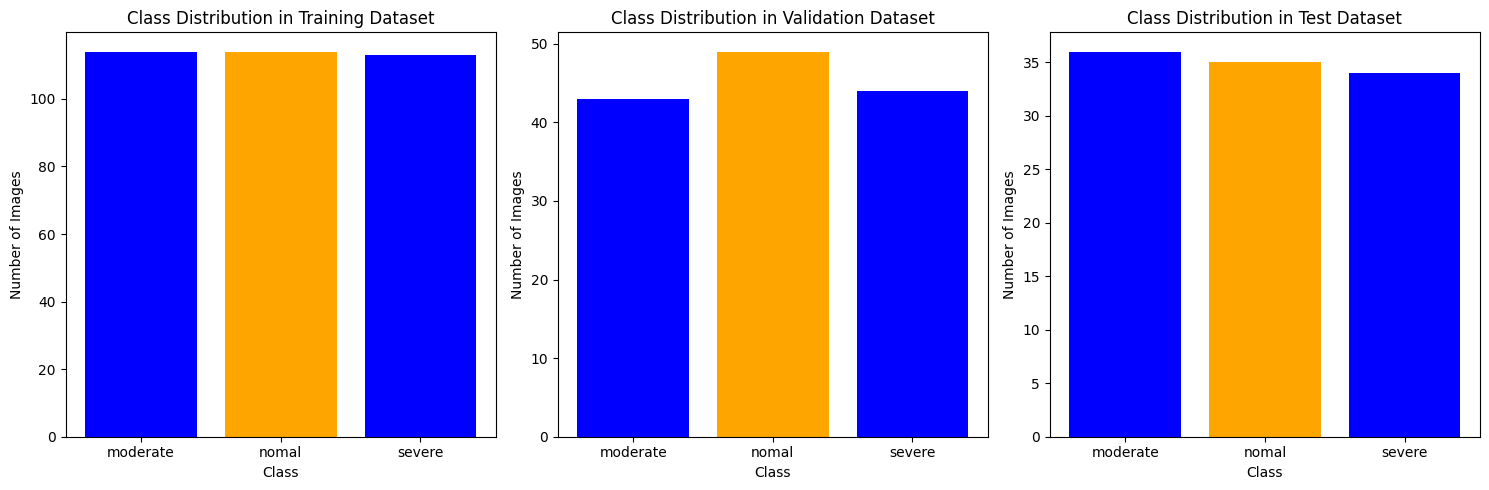

In [37]:
def plot_class_distribution(class_counts, dataset_name, ax):
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    ax.bar(labels, counts, color=['blue', 'orange'])
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title(f'Class Distribution in {dataset_name} Dataset')

_, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_class_distribution(train_class_counts, "Training", axes[0])
plot_class_distribution(validation_class_counts, "Validation", axes[1])
plot_class_distribution(test_class_counts, "Test", axes[2])

plt.tight_layout()
plt.show()

In [38]:
# import random

# oversample_datagen = ImageDataGenerator(
#     rotation_range=45,
#     shear_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
# )

# def oversample_class(input_folder, target_count):
#     current_images = os.listdir(input_folder)
#     num_current = len(current_images)
#     print(f"Oversampling {input_folder}: {num_current} -> {target_count}")

#     for i in range(target_count - num_current):
#         img_name = random.choice(current_images)
#         img_path = os.path.join(input_folder, img_name)

#         img = load_img(img_path)
#         img_array = img_to_array(img)
#         img_array = np.expand_dims(img_array, axis=0)

#         aug_iter = oversample_datagen.flow(img_array, batch_size=1)
#         aug_img = next(aug_iter)[0].astype('uint8')

#         save_img(os.path.join(input_folder, f"aug_{i}.jpg"), aug_img)


# target_samples = 139 
# oversample_class(os.path.join(train_dir, 'moderate'), target_samples)
# oversample_class(os.path.join(train_dir, 'nomal'), target_samples)  
# oversample_class(os.path.join(train_dir, 'severe'), target_samples)  

# print("Training data class:", count_images_in_folder(train_dir))
# print("Validation data class:", count_images_in_folder(validation_dir))
# print("Test data class:", count_images_in_folder(test_dir))

In [39]:
# _, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot_class_distribution(count_images_in_folder(train_dir), "Training", axes[0])
# plot_class_distribution(count_images_in_folder(validation_dir), "Validation", axes[1])
# plot_class_distribution(count_images_in_folder(test_dir), "Test", axes[2])

# plt.tight_layout()
# plt.show()

In [40]:
# model = Sequential([
#     base_model,
#     AveragePooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(1024, kernel_regularizer=l2(0.001), activity_regularizer=l1(0.001), bias_regularizer=l1(0.001), activation='relu'),
#     BatchNormalization(),
#     Dropout(0.1),
#     Dense(3, activation='softmax')
# ])

In [41]:
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

base_model = EfficientNet(
    input_shape=(img_height, img_width, 3),  # Ukuran input gambar
    include_top=False,  # Tidak termasuk fully connected layer bawaan
    weights='imagenet'                      
)

base_model.trainable = False

model = Sequential([
    base_model,
    AveragePooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu',  kernel_regularizer=l2(0.00016), bias_regularizer=l2(0.00016)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu',  kernel_regularizer=l2(0.00016),bias_regularizer=l2(0.00016)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate = 0.000167),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 3, 3, 1280)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,533,478 (21.11 MB)

 Trainable params: 1,483,523 (5.66 MB)

 Non-trainable params: 4,049,955 (15.45 MB)

In [42]:
training = model.fit(
    train_generator,
    epochs=25,                             
    validation_data=validation_generator
)

Epoch 1/25


c:\Users\Ichwan\.conda\envs\forge-ultralytic\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 382ms/step - accuracy: 0.3550 - loss: 1.6988 - val_accuracy: 0.4779 - val_loss: 1.1419
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.5599 - loss: 1.0304 - val_accuracy: 0.5588 - val_loss: 0.9119
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.6471 - loss: 0.9102 - val_accuracy: 0.6765 - val_loss: 0.8022
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.7646 - loss: 0.7255 - val_accuracy: 0.6691 - val_loss: 0.7503
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.6406 - loss: 0.8750 - val_accuracy: 0.7132 - val_loss: 0.7085
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.7143 - loss: 0.7378 - val_accuracy: 0.6691 - val_loss: 0.6958
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.6692 - loss: 0.7607 - val_accuracy: 0.6912 - val_loss: 0.6972
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.7900 - loss: 0.5983 - val_accuracy: 0.6838 - val

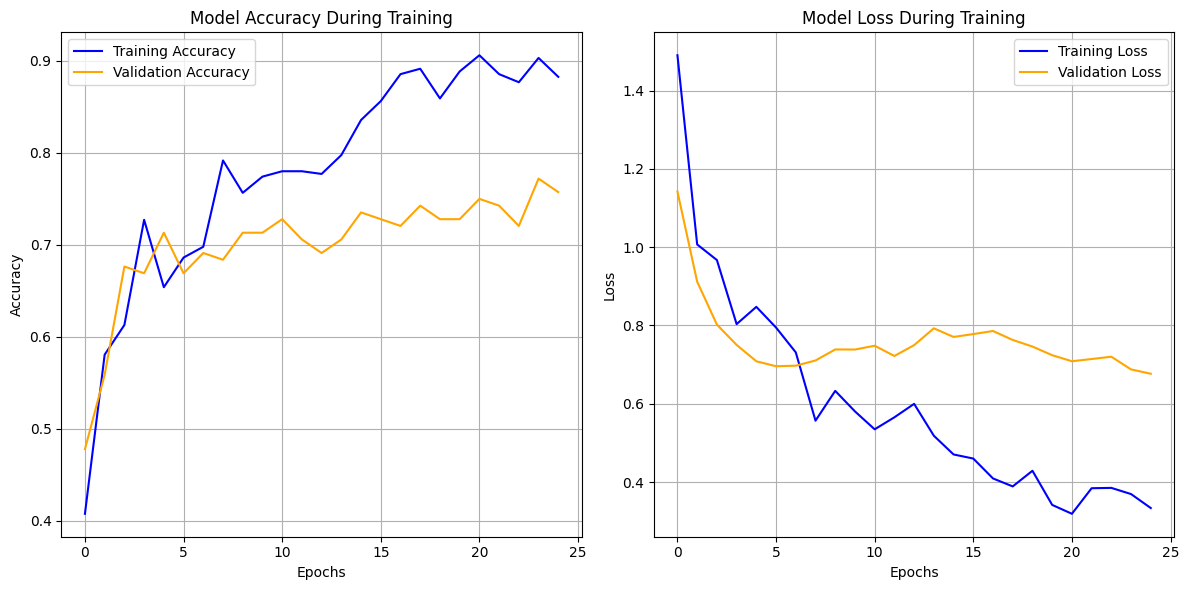

In [50]:
train_accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
train_loss = training.history['loss']
val_loss = training.history['val_loss']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy During Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss During Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [51]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.6855 - loss: 0.9966
Test Loss: 0.7692223787307739
Test Accuracy: 0.7428571581840515


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


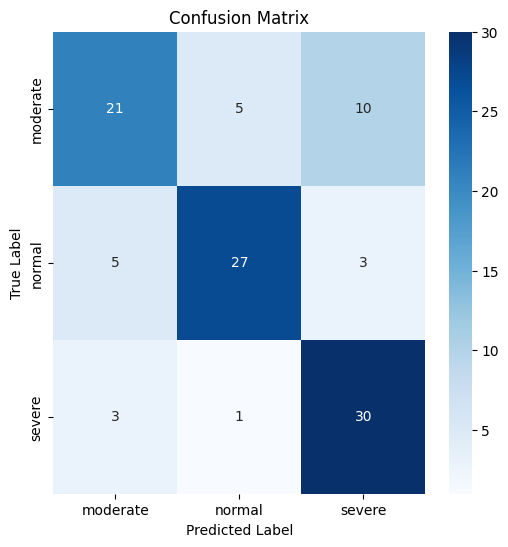

              precision    recall  f1-score   support

    moderate       0.72      0.58      0.65        36
      normal       0.82      0.77      0.79        35
      severe       0.70      0.88      0.78        34

    accuracy                           0.74       105
   macro avg       0.75      0.75      0.74       105
weighted avg       0.75      0.74      0.74       105



In [52]:

y_true = test_generator.classes

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1) 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['moderate', 'normal', 'severe'],
            yticklabels=['moderate', 'normal', 'severe'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=['moderate', 'normal', 'severe']))


### Testing Klasifikasi

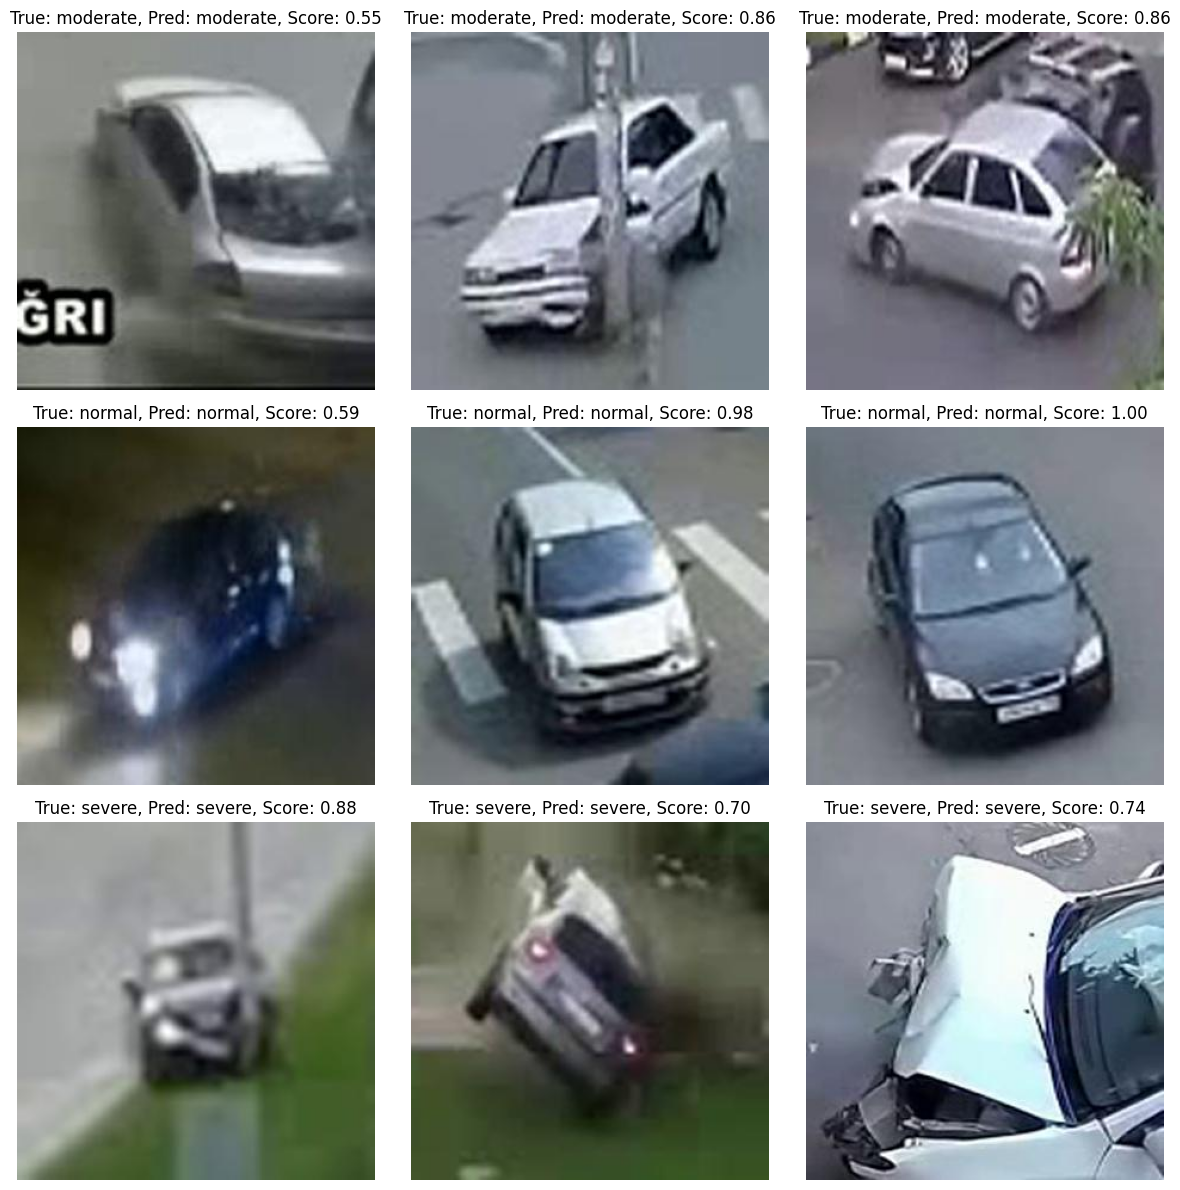

In [ ]:
image_paths = test_generator.filepaths
unique_labels = np.unique(y_true) 
images_per_label = 3  

plt.figure(figsize=(12, 4 * len(unique_labels))) 

for label_idx, label in enumerate(unique_labels):
    classified_for_label = np.where((y_true == label) & (y_true == y_pred))[0]
    
    if len(classified_for_label) == 0:
        continue  
    
    selected_indices = classified_for_label[:images_per_label]

    for img_idx, idx in enumerate(selected_indices):
        original_img = Image.open(image_paths[idx])

        predicted_class = int(y_pred[idx])
        pred_probability = np.max(y_pred_prob[idx])

        plt.subplot(len(unique_labels), images_per_label, label_idx * images_per_label + img_idx + 1)
        plt.imshow(original_img)
        plt.title(f"True: {['moderate', 'normal', 'severe'][y_true[idx]]}, "
                  f"Pred: {['moderate', 'normal', 'severe'][predicted_class]}, "
                  f"Score: {pred_probability:.2f}")
        plt.axis('off')

plt.tight_layout()
plt.show()


### Miss klasifikasi

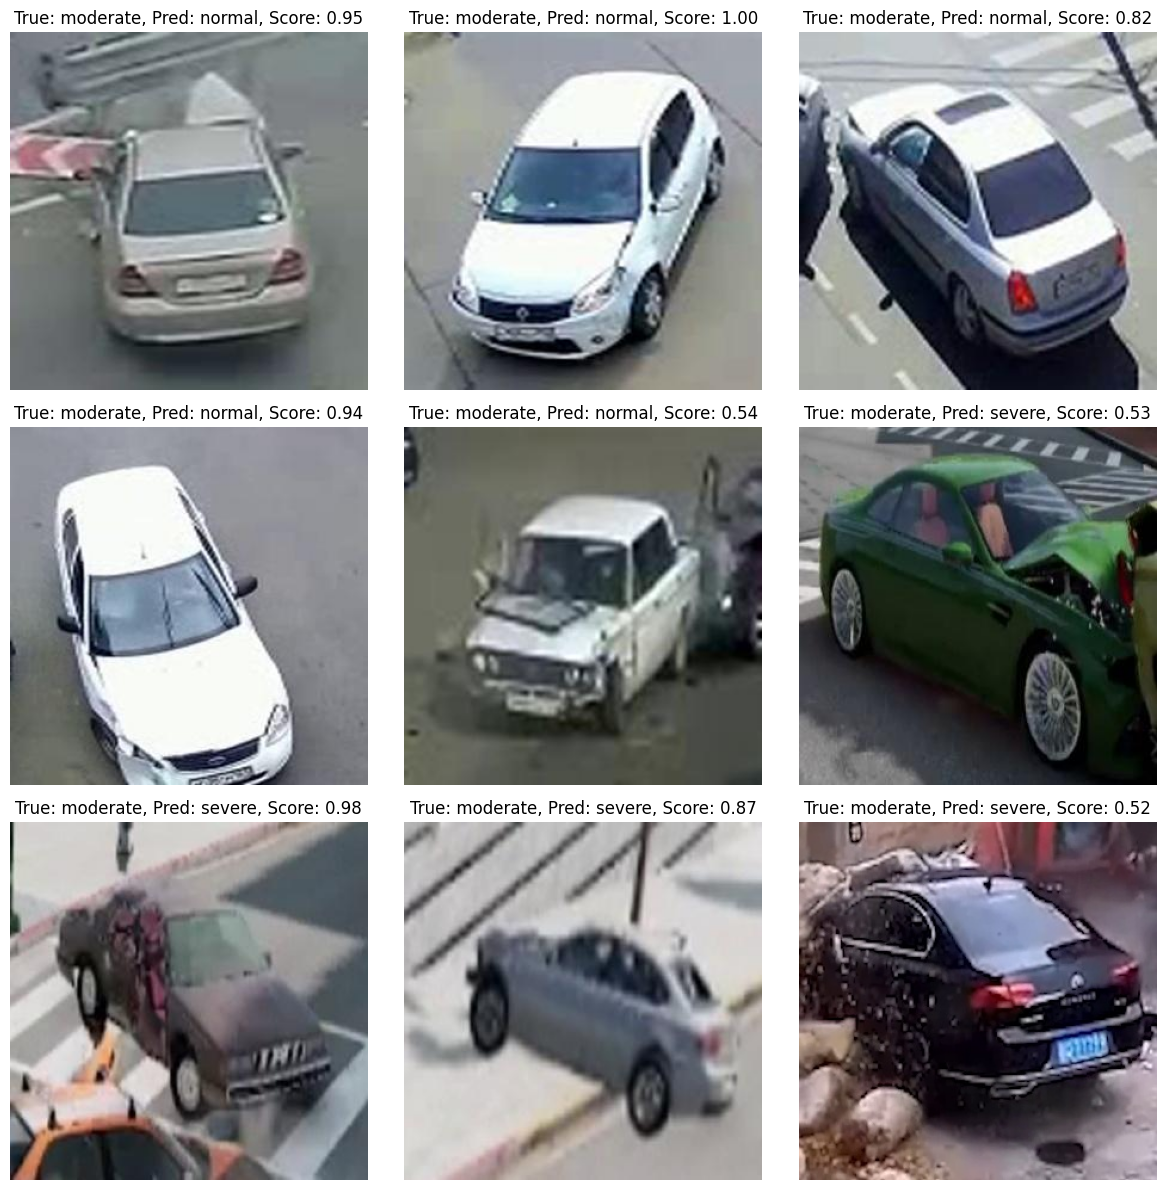

In [54]:
image_paths = test_generator.filepaths

misclassified_indices = np.where(y_true != y_pred)[0]

plt.figure(figsize=(12, 12))  

for i, idx in enumerate(misclassified_indices[:9]): 
    original_img = Image.open(image_paths[idx]) 

    predicted_class = int(y_pred[idx])
    pred_probability = np.max(y_pred_prob[idx])  

    plt.subplot(3, 3, i + 1)
    plt.imshow(original_img)  
    plt.title(f"True: {['moderate', 'normal', 'severe'][y_true[idx]]}, "
              f"Pred: {['moderate', 'normal', 'severe'][predicted_class]}, "
              f"Score: {pred_probability:.2f}")  
    plt.axis('off')

plt.tight_layout()
plt.show()


In [55]:
model.save('EffecientNetB0.h5')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

classifier = load_model("EffecientNetB0.h5")

image_path = "assets/datasetv2/test/nomal/sintetic-49-_jpg.rf.10b1bc62104c7619e2184f8ed1fc9c49.jpg"
image = cv2.imread(image_path)
image_resized = cv2.resize(image, (224, 224))
image_array = np.expand_dims(image_resized, axis=0).astype('float32') / 255.0

# Prediksi
prediction = classifier.predict(image_array)
print(f"Prediksi Model: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi Model: [[0.05240027 0.94547373 0.00212595]]
